### Restaurant Recommendation - Custom Chatbot

Building chatbot that helps users find the perfect restaurant for any occasion. It can consider factors like cuisine preferences, dietary restrictions, location, and user reviews to make tailored recommendations.

1. Collect the data for restaurant details from open data sources
2. Exploratory Data Analysis to know the dataset - To make the chatbot perform better in terms laying gaurdrails 
  - Identifying the columns required to base the recommendation assistant
  - Missing data evaluation to handle or ignore 
  - Finalizing the features for chatbot
3. Building the chatbot that recommends top 3 restaurants based on perferences
  - User intent clarification - bot gathering information from user
  - Mapping the perferences with restaurant
  - Recommending top 3 restaurant based on requirements

In [1]:
# ! pip uninstall openai -y
# ! pip install --upgrade openai


In [2]:
## importing libraries for openai and pandas 
# ! pip install openai==0.28
# import openai
from openai import OpenAI
# client = OpenAI()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re

### importing other libraries for proressing 
import json, ast
import os
import warnings
warnings.filterwarnings("ignore")

#### Setting the OpenAI key
with open("C:/Users/SHAMBHAVVISEN/Downloads/OpenAI_API_Key.txt") as f:
    api = f.read().strip()

client = OpenAI(api_key=api)



### 1. Selected dataset is bengaluru restaurants

In [3]:
## The chosen dataset is bengaluru restaurants dataset
beng_restaurants = pd.read_csv('bengaluru_restaurants.csv')
beng_restaurants.shape
## Renaming the columns for better readability
beng_restaurants.columns=beng_restaurants.columns.str.replace(' ',"")

### 2. Exploratory Data Analysis  for the chosen dataset

In [5]:
### list of columns in the dataset with formatting
print("List of columns in the dataset:")
for col in beng_restaurants.columns:
    print(f"- {col} - {type(col)}")

###
def convert_str_to_float(data,column_names=list):

    """Convert a string to float, handling commas and empty strings."""

    for col in column_names:
        data[col]=np.round(data[col].astype('float64',errors='ignore'),2)
    return data
### convert the columns that has string values to float
beng_restaurants=convert_str_to_float(beng_restaurants,
                                      column_names=['numberOfReviews','rating','rankingDenominator',
                                                     'rankingPosition','rawRanking','latitude','longitude']
                                      )

List of columns in the dataset:
- name - <class 'str'>
- address - <class 'str'>
- addressObj/country - <class 'str'>
- addressObj/postalcode - <class 'str'>
- addressObj/state - <class 'str'>
- cuisine - <class 'str'>
- description - <class 'str'>
- DietaryRestrictions - <class 'str'>
- Dishes - <class 'str'>
- Features - <class 'str'>
- latitude - <class 'str'>
- longitude - <class 'str'>
- localAddress - <class 'str'>
- MealType - <class 'str'>
- numberOfReviews - <class 'str'>
- phone - <class 'str'>
- rankingDenominator - <class 'str'>
- rankingPosition - <class 'str'>
- rating - <class 'str'>
- rawRanking - <class 'str'>


**The relevant set of columns from the data are:**
- name

**To understand the eating perference**
- cuisine
- DietaryRestrictions 

**To understand the location perference**
- localAddress
- latitude
- longitude

**To understand the occassion**
- MealType

**Recommendation validation metrices**
- numberofReviews
- rating
- RankingDemoniator
- rawRanking


In [39]:
### Missing data analysis
columns_of_interest=["name","cuisine","DietaryRestrictions","MealType","localAddress","latitude","longitude",
                     "numberOfReviews","rating","rankingDenominator","rankingPosition","rawRanking"]
print("Missing info in the dataset:")
print(beng_restaurants[beng_restaurants[columns_of_interest].isnull().any(axis=1)][columns_of_interest].shape)

### Mising data evaluation
print("Missing data evaluation:")
print(beng_restaurants[columns_of_interest].isnull().sum()/beng_restaurants.shape[0]*100)

Missing info in the dataset:
(4110, 12)
Missing data evaluation:
name                    0.000000
cuisine                 0.000000
DietaryRestrictions     0.000000
MealType                0.000000
localAddress            0.000000
latitude                3.541061
longitude               3.541061
numberOfReviews         0.000000
rating                 41.007427
rankingDenominator     40.856743
rankingPosition        40.856743
rawRanking             40.856743
dtype: float64


#### Data Visualization

In [41]:
def unique_visuals(data=None,column=None, col_name=str):
    df_cusines=pd.DataFrame(data.query(f'{column}!=""')[column].value_counts())
    df_cusines.reset_index(inplace=True)
    df_cusines.columns=[col_name,'Count']

    fig=plt.figure(figsize=(10,5))
    sns.barplot(x='Count',y=col_name,data=df_cusines.head(30),palette='viridis')
    plt.title(column+' - Top 20 '+'('+str(df_cusines.shape[0]) + " "+col_name +')')
    plt.show()

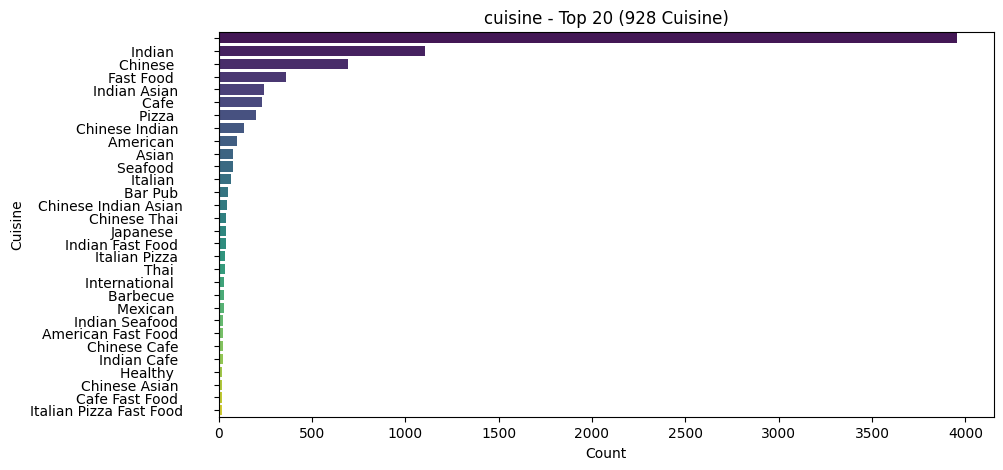

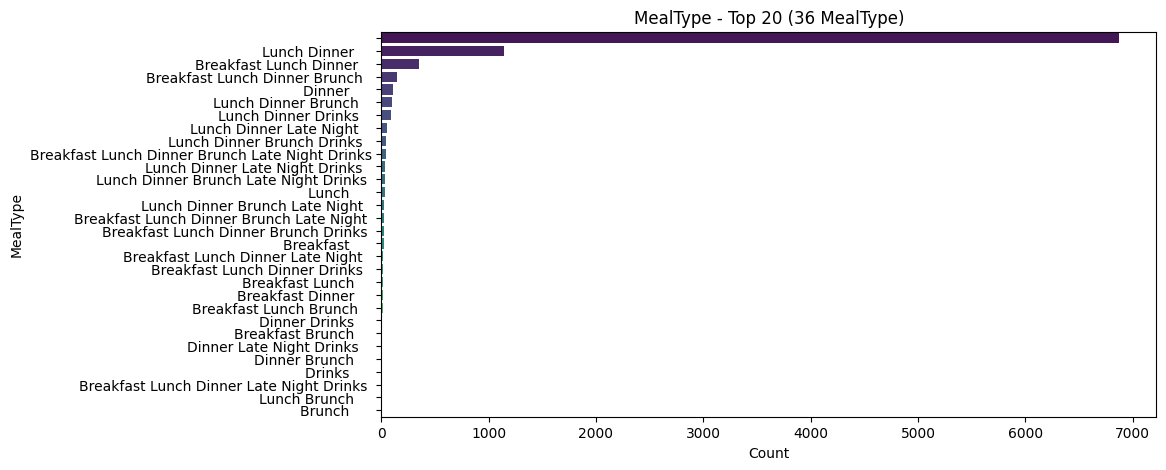

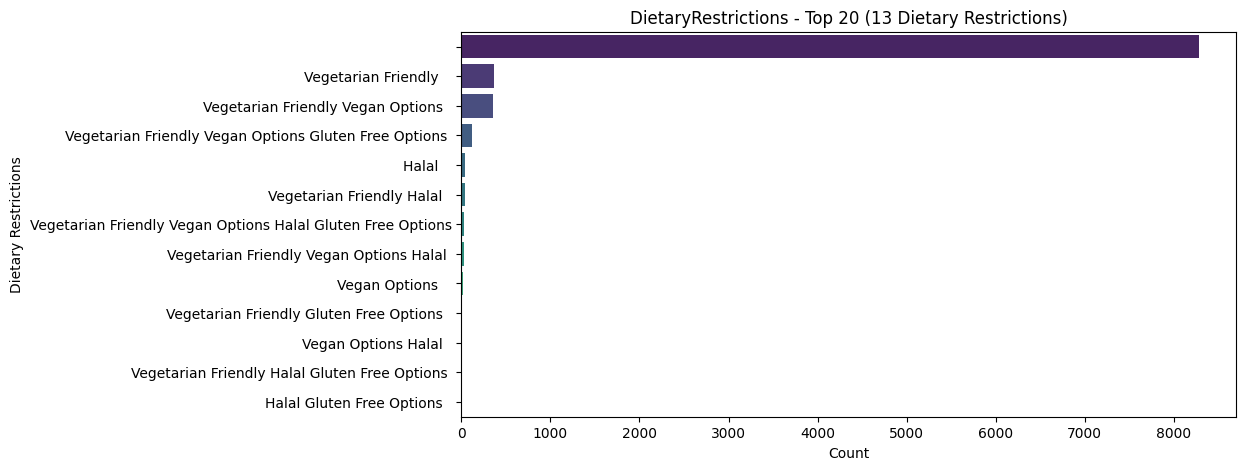

In [43]:
unique_visuals(beng_restaurants, 'cuisine',col_name='Cuisine')
unique_visuals(beng_restaurants, 'MealType',col_name='MealType')
unique_visuals(beng_restaurants, 'DietaryRestrictions',col_name='Dietary Restrictions')


In [8]:
beng_restaurants.to_csv('bengaluru_restaurants_cleaned.csv',index=False)

Column of interests are within the missing threshold band of 50%. Hence going ahead with the available data unchanged. Because in the event of filtering these missing values are going to ignored anyways, so choosing to not handle them.

#### Building a restaurant recommendation chatbot

1. Stage 1 - Gather user's perferences - Intent clarification, extract the dictionary from the string
2. Stage 2 - Preference mapping - Map the perference with data
3. Step  3 - Recommendation of Restaurants
4. Step  4 - Evaluation of the obtained results

### Invoking conversation by prompt engineering 

In [9]:
def initialize_conversation():
    delimiter = "####"

    system_message = f"""
    You are an expert in recommending restaurants based on user personal preferences and requirements.
    Your task is to recommend top three restaurants based on user's perferences and requirements.
    You will ask questions to understand the user's profile and requirements two questions per conversation until you have enoughh information to recommend the top three restaurants. 
    If the user mentions 'vegetarian', 'vegan', or 'gluten-free', treat them as dietary restrictions and store them under DietaryRestrictions feature.
    If the user mentions 'breakfast', 'lunch', or 'dinner', treat them as meal type and store them under meal type feature.
    If the user mentions their current location, store it under current location feature.
    If the user mentions their preferred location, store it under preferred location feature.
    Try to understand the user's requirements based on features: ('cuisine','meal type', 'DietaryRestrictions', 'current location', 'preferred location').
    Don't ask any questions if the user has already provided enough information to recommend the top three restaurants. Display the user info in a dictionary format.
    Calculate the distance from the user's current location to the preferred location, if provided.
    If the user has not provided their current location, ask for it.
    If the user has not provided their preferred location, ask for it.
    calculate the latitude and longitude of the user's current location and preferred location, if provided. else get it from the user
    If the user has not provided enough information, ask questions to clarify their needs.
    If the user has provided enough information, recommend the top three restaurants based on their preferences by matching the dataset available and requirements. 
    
    
    {delimiter} 
    Here are certain guidelines that you need to follow:
    Don't ask questions when all the features ('cuisine','meal type','DietaryRestrictions', 'current location', 'preferred location') are already provided by the user
    Don't ask questions about more than 2 features at a time.
    The recommendations are only restricted to bangalore restaurants, other locations are not supported. 
    Incase of other locations, please mention that you are not able to recommend restaurants outside of bangalore.
    Recommend the top3 restaurants in the following format:
    Start with a brief summary of each restaurants in the following format, in decreasing order of rating and ascending order of distance from the current location:
    1. <Restaurant Name> : <Dishes served, cuisne >, <ratings and number of reviews> <distance from current location in km>
    2. <Restaurant Name> : <Dishes served, cuisne >, <ratings and number of reviews> <distance from current location in km>
    3. <Restaurant Name> : <Dishes served, cuisne >, <ratings and number of reviews> <distance from current location in km>
    {delimiter}

    {delimiter}To find the top3 restaurants, you need to have the following chain of thoughts:
    Thought 1: Ask one question to understand the user's profile and requirements. \n
    If their primary perference for the cuisine is unclear. Ask another question to comprehend their needs.
    Answer "Yes" or "No" to indicate if you understand the requirements. \n
    If yes, proceed to the next step. Otherwise, rephrase the question to capture their profile. \n

    Thought 2: Now, you are trying to understand the requirements for other features which you couldn't in the previous step.
    Ask questions to strengthen your understanding of the user's profile.
    Don't ask questions about more than 2 features at a time.
    Answer "Yes" or "No" to indicate if you understood all the needs of the features and are confident about the same.
    If yes, move to the next Thought. If no, ask question on the features whose needs you are unsure of. \n
    It is a good practice to ask question with a sound logic as opposed to directly citing the feature you want to understand the need for.
    
    Thought 3: Now, if the user dos not have any perferences for any of the features after above two steps. you can consider those features types as "NA"
    and proceed to finalize the user profile and requirements.
    Make the recommendations by mapping the user profile and requirements with the dataset from bengaluru restaurants.

    Thought 4: Now, you have the user profile and requirements in a json format. You can use this to recommend the top three restaurants based on the user's preferences.

    {delimiter}
    {delimiter}

    {delimiter} Here is a sample conversation between the user and assistant:
    Assistant: "Hello! I'm here to help you find the perfect restaurant for any occassions that suits your perferences. Could you please share your requirements?"
    User: "Hi, I would like to have an exquisite Italian style paste near Indhira nagar."
    Assistant: "Great! I understand that you are looking for an Italian restaurant near Indhira Nagar. Do you have any specific dietary restrictions or preferences, such as vegetarian, vegan, or gluten-free?"
    User: "No, I don't have any dietary restrictions."
    Assistant: "Thank you for the information. So, you are looking for an Italian restaurant near Indhira Nagar without any dietary restrictions. Do you have a preference for the type of meal, such as breakfast, lunch, or dinner?"
    User: "I would prefer a dinner option."
    Assistant: "Got it, where are you currently located and mentioned the perferred location? This will help me find restaurants that are close to you."
    User: "I am currently at Indhira Nagar, and I would like to find restaurants in that area."
    Assistant: "Thank you for the information! So, to summarize, you are looking for an Italian restaurant for dinner near Indhira Nagar, without any dietary restrictions, and you are currently at Indhira Nagar. Is that correct?"
    User: "Yes, that sounds good."
    Assistant: "Perfect!
    Based on your preferences, I will now recommend the top three Italian restaurants near Indhira Nagar for dinner. Please hold on for a moment while I gather the information."
    "Got it! You are looking for an Italian restaurant near Indhira Nagar for dinner, without any dietary restrictions. Based on your preferences, here are the top three recommendations:\n
    1. <Restaurant Name> : <Dishes served, cuisine>, <ratings and number of reviews> \n
    2. <Restaurant Name> : <Dishes served, cuisine>, <ratings and number of reviews> \n
    3. <Restaurant Name> : <Dishes served, cuisine>, <ratings and number of reviews> 
    {delimiter}


    Start with a short welcome message and encourage the user to share their requirements.
    """
    conversation = [{"role": "system", "content": system_message }]
    return conversation

#### Function Calling 

In [10]:
functions = [
    {
        "name": "recommend_restaurants",    # MANDATORY
        "description": "Recommend top three restaurants based on user's preferences and requirements like cuisine, dietary restrictions, current location, preferred location, and meal type.",
        "parameters": {
            "type": "object",
            "properties": {
                "cuisine": {"type": "string", "description": "Preferred cuisine"},
                "dietary_restrictions": {"type": "string", "description": "Any dietary restrictions"},
                "current_location": {"type": "string", "description": "User's current location"},
                "preferred_location": {"type": "string", "description": "Preferred restaurant area"},
                "meal_type": {"type": "string", "description": "Breakfast, lunch, or dinner"}
            },
            "required": ["cuisine", "dietary_restrictions","meal_type", "preferred_location","current_location"]
        }
    }
]

### Chat completion function

In [ ]:
def get_chat_completion(messages):
    response = client.chat.completions.create(
        model="gpt-4-0613",
        messages=messages,
        temperature=0,
        seed=1234,
        functions=functions,
        function_call="auto"
    )
    return response.choices[0].message 
   

### Moderation Check

In [12]:
### Moderation check function
def moderation_check(user_input):
    # Call the OpenAI API to perform moderation on the user's input.
    response = client.moderations.create(input=user_input)

    # print(response)

    # Extract the moderation result from the API response.
    moderation_output = response.results[0].flagged
    # Check if the input was flagged by the moderation system.
    if response.results[0].flagged == True:
        # If flagged, return "Flagged"
        return "Flagged"
    else:
        # If not flagged, return "Not Flagged"
        return "Not Flagged"
### Testing the moderation check function
user_input = "I want to blast a restaurant."
moderation_result = moderation_check(user_input)
print(f"Moderation result for user input '{user_input}': {moderation_result}")

Moderation result for user input 'I want to blast a restaurant.': Flagged


### Perference Maping and Recommendation Layer

In [ ]:

### Defining the function to filter the data based on user preferences
def filter_data_based_on_preferences(user_requirement):

    """Filters the dataset based on user preferences."""
    # Extracting user preferences
    data= pd.read_csv('bengaluru_restaurants_cleaned.csv')
    user_requirement = ast.literal_eval(user_requirement) if isinstance(user_requirement, str) else user_requirement
    cuisine= user_requirement.get('cuisine', None)
    dietary_restrictions = user_requirement.get('dietary_restrictions', None)
    current_location = user_requirement.get('current_location', None)
    preferred_location = user_requirement.get('preferred_location', None)
    meal_type = user_requirement.get('meal_type', None)

    ### Creating a flag as 1 to indicate if the user preferences are valid
    data['cuisine_flag'] = np.where(data['cuisine'].str.lower().str.contains(cuisine.lower()), 1, 0) if cuisine else 1
    data['dietary_restrictions_flag'] = np.where(data['DietaryRestrictions'].str.lower().str.contains(dietary_restrictions.lower()), 1, 0) if dietary_restrictions else 1
    # data['current_location_flag'] = np.where(data['localAddress'].str.lower().str.contains(current_location.lower()), 1, 0) if current_location else 1
    data['preferred_location_flag'] = np.where(data['localAddress'].str.lower().str.contains(preferred_location.lower()), 1, 0) if preferred_location else 1
    data['meal_type_flag'] = np.where(data['MealType'].str.lower().str.contains(meal_type.lower()), 1, 0) if meal_type else 1
    ### 
    data["user_preference_score"]=data['cuisine_flag'] + data['dietary_restrictions_flag'] + data['preferred_location_flag'] + data['meal_type_flag'] #+ data['current_location_flag'] 

    ### Sort the data by most matched perferences and highest rating 
    data=data.sort_values(['user_preference_score','rating'], ascending=[False, False])
    top_restuarants=data.head(3)
    return top_restuarants.to_json(orient='records')

def recommend_restaurants(user_preferences):
    """Recommends top three restaurants based on user preferences."""
    # Filter the dataset based on user preferences
    filtered_data = filter_data_based_on_preferences(user_preferences)  
    # Convert the filtered data to a DataFrame
    filtered_df = pd.read_json(filtered_data, orient='records')
    # Check if there are any restaurants that match the user's preferences
    if filtered_df.empty:
        return "No restaurants found matching your preferences."
    else:
        # Format the recommendations
        recommendations = []    
        for index, row in filtered_df.iterrows(): 
            recommendation = f"{index + 1}. {row['name'].strip()}: {row['cuisine'].strip()}, rating of {row['rating']} ({row['numberOfReviews']} reviews) - here are the dishes served: {row['Dishes']}"
            recommendations.append(recommendation)
        return "\n".join(recommendations)  


### Chatbot layout and dialogue management system

In [33]:
def dialogue_mgmt_system():
    print("Welcome to Restaurant Recommendation Assistance")
    conversation = initialize_conversation()
    introduction = get_chat_completion(conversation).content
    print(introduction + '\n')
    user_input = ""
    while(user_input != "exit"):
      user_input = input("Please enter your requirements (type 'exit' to quit): ")
      if moderation_check(user_input) == "Flagged":
        print("Your input has been flagged by the moderation system. Please rephrase your input.")
        continue
      print("User:",user_input)
      conversation.append({"role": "user", "content": user_input})
      # Step 1: Pass the user input to GPT
      response_assistant = get_chat_completion(conversation)
      if response_assistant.function_call:
        print("\nThank you for providing all the information. Kindly wait, while I fetch the products\n")
        # Step 2: Extract top3 restaurants by calling the external function
        function_name = response_assistant.function_call.name
        function_args = json.loads(response_assistant.function_call.arguments)
        function_response = recommend_restaurants(function_args)
        # function_response = recommend_restaurants(sorted_restauranrts)
        if len(function_response) == 0:
          print("Sorry, we do not have any restaurants matching with your requirement. Connecting you to a human expert.")
          break
        # Step 3: send the info on the function call and function response to GPT
        conversation.append(response_assistant)
        conversation.append(
            {
                "role": "function",
                "name": function_name,
                "content": function_response,
            }
        )
        recommendation = get_chat_completion(conversation)
        conversation.append({"role": "assistant", "content": recommendation.content})
        print("\n"+ "Assistant: "+ recommendation.content + "\n")
      else:
        conversation.append({"role": "assistant", "content": response_assistant.content})
        print("\n" + "Assistant: "+ response_assistant.content + "\n")

In [36]:
dialogue_mgmt_system()

Welcome to Restaurant Recommendation Assistance
Assistant: "Hello! I'm here to help you find the perfect restaurant for an occasion that suits your preferences. Could you please share your requirements?"

User: I want to have indian breakfast

Assistant: Great! You'd like to have Indian breakfast. Could you please inform where would you prefer to have breakfast and where are you currently located? These details will help me find the best possible options for you.

User: I'm in bellandur and find places in bellandur itself

Thank you for providing all the information. Kindly wait, while I fetch the products


Assistant: Based on your preferences, here are the top three Indian restaurants in Bellandur for breakfast:

1. Kava: Serves American Indian European Asian dishes, rated 4 stars with 33 reviews. 

2. Spice It Restaurant: Serves Indian International Asian dishes, rated 4 stars with 57 reviews.

3. Skylit: Serves Indian Asian dishes, rated 4 stars with 43 reviews. 

I hope you enjoy 

#### Evaluation of recommended restaurants

In [ ]:

def eval_data(user_requirement):

    """Filters the dataset based on user preferences."""
    # Extracting user preferences
    data= pd.read_csv('bengaluru_restaurants_cleaned.csv')
    user_requirement = ast.literal_eval(user_requirement) if isinstance(user_requirement, str) else user_requirement
    cuisine= user_requirement.get('cuisine', None)
    dietary_restrictions = user_requirement.get('dietary_restrictions', None)
    current_location = user_requirement.get('current_location', None)
    preferred_location = user_requirement.get('preferred_location', None)
    meal_type = user_requirement.get('meal_type', None)

    ### Creating a flag as 1 to indicate if the user preferences are valid
    data['cuisine_flag'] = np.where(data['cuisine'].str.lower().str.contains(cuisine.lower()), 1, 0) if cuisine else 1
    data['dietary_restrictions_flag'] = np.where(data['DietaryRestrictions'].str.lower().str.contains(dietary_restrictions.lower()), 1, 0) if dietary_restrictions else 1
    # data['current_location_flag'] = np.where(data['localAddress'].str.lower().str.contains(current_location.lower()), 1, 0) if current_location else 1
    data['preferred_location_flag'] = np.where(data['localAddress'].str.lower().str.contains(preferred_location.lower()), 1, 0) if preferred_location else 1
    data['meal_type_flag'] = np.where(data['MealType'].str.lower().str.contains(meal_type.lower()), 1, 0) if meal_type else 1
    ### 
    data["user_preference_score"]=data['cuisine_flag'] + data['dietary_restrictions_flag'] + data['preferred_location_flag'] + data['meal_type_flag'] #+ data['current_location_flag'] 

    ### Sort the data by most matched perferences and highest rating 
    data=data.sort_values(['user_preference_score','rating'], ascending=[False, False])

    return data



In [ ]:
### This user preferrences are the result of 
user_perference={"cuisine":"indian", 
                 "dietary_restrictions":"veg",
                 "meal_type":"breakfast", 
                 "preferred_location":"bellandur",
                 "current_location":"Bellandur"}

ev_data=eval_data(user_perference)
ev_data[['name','rating','cuisine_flag',
       'dietary_restrictions_flag', 'preferred_location_flag',
       'meal_type_flag', 'user_preference_score']].head()

,name,rating,cuisine_flag,dietary_restrictions_flag,preferred_location_flag,meal_type_flag,user_preference_score
323,Kava,4.0,1,1,1,1,4
380,Spice It Restaurant,4.0,1,1,1,1,4
480,Skylit,4.0,1,1,1,1,4
69,Caraway Kitchen,5.0,1,1,0,1,3
77,The Creek,5.0,1,1,0,1,3


The recommendations are correctly based on the user perferences and the best restuarants are selected based on the ratings and number of reviewers. The chatbot is performing better on the conversational and intent clarification level as well. Moderation check is in place along with the restrictions of recommendation only within bangalore locality.